# Order-Line Out-of-Stock Risk Predictor

**Model Type:** Binary Classification (LightGBM)  
**Target:** Predict probability that `delivered_qty < ordered_qty` for each sales order line  
**Purpose:** Pre-delivery shortage risk assessment for warehouse orchestration

---

## Notebook Structure

1. Data Loading & EDA
2. Label Creation
3. Feature Engineering
4. Train/Val/Test Split
5. Model Training
6. Model Evaluation
7. Model Calibration
8. SHAP Analysis
9. Model Export


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# GPU Detection and Setup
import subprocess
import sys

print("Checking for GPU availability...")
try:
    import torch
    if torch.cuda.is_available():
        print(f"✓ CUDA GPU detected: {torch.cuda.get_device_name(0)}")
        print(f"  CUDA Version: {torch.version.cuda}")
        print(f"  GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
        USE_GPU = True
    else:
        print("✗ No CUDA GPU detected. Using CPU.")
        USE_GPU = False
except ImportError:
    print("✗ PyTorch not installed. Checking for GPU with LightGBM...")
    USE_GPU = False

# Try to use cuDF for GPU-accelerated pandas operations
try:
    import cudf
    print("✓ cuDF (RAPIDS) detected - will use GPU-accelerated pandas operations")
    USE_CUDF = True
except ImportError:
    print("✗ cuDF not available - using standard pandas")
    USE_CUDF = False

print(f"\nGPU Acceleration: {'ENABLED' if USE_GPU else 'DISABLED'}")
print(f"cuDF Acceleration: {'ENABLED' if USE_CUDF else 'DISABLED'}")

Checking for GPU availability...
✓ CUDA GPU detected: NVIDIA L4
  CUDA Version: 12.6
  GPU Memory: 23.80 GB
✓ cuDF (RAPIDS) detected - will use GPU-accelerated pandas operations

GPU Acceleration: ENABLED
cuDF Acceleration: ENABLED


In [3]:
%pip install pandas>=2.0.0 numpy>=1.24.0 scikit-learn>=1.3.0 lightgbm>=4.0.0 matplotlib>=3.7.0 seaborn>=0.12.0 joblib>=1.3.0 jupyter>=1.0.0 notebook>=7.0.0 shap>=0.42.0 category_encoders>=2.6.0


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
import os
from pathlib import Path

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_score, recall_score, confusion_matrix,
    roc_curve, precision_recall_curve, classification_report
)
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
import lightgbm as lgb
from category_encoders import TargetEncoder
import joblib
import shap

# GPU libraries (optional)
try:
    import cudf
    import cupy as cp
    GPU_AVAILABLE = True
except ImportError:
    GPU_AVAILABLE = False

# Plotting settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"LightGBM version: {lgb.__version__}")
print(f"GPU Support: {'✓ Available' if GPU_AVAILABLE else '✗ Not available'}")


Libraries imported successfully!
Pandas version: 2.2.2
LightGBM version: 4.6.0
GPU Support: ✓ Available


## 1. Data Loading & Exploratory Data Analysis

### Google Drive Data Source

**Folder:** https://drive.google.com/drive/folders/1m1a1uCX_SXp8nTzfkuc1UO-XEdn_DkuW


In [7]:
# Load data files
print("\n" + "="*80)
print("LOADING DATA FILES")
print("="*80)

import time
start = time.time()

data_dir = "/content/drive/MyDrive/hackathon"

sales_df = pd.read_csv(data_dir + '/valio_aimo_sales_and_deliveries_junction_2025.csv')
replacement_df = pd.read_csv(data_dir + '/valio_aimo_replacement_orders_junction_2025.csv')
purchases_df = pd.read_csv(data_dir + '/valio_aimo_purchases_junction_2025.csv')

print(f"\n✓ Data loaded successfully in {time.time()-start:.2f}s\n")
print(f"Sales & Deliveries: {sales_df.shape[0]:,} rows × {sales_df.shape[1]} columns")
print(f"Replacement Orders: {replacement_df.shape[0]:,} rows × {replacement_df.shape[1]} columns")
print(f"Purchase Orders:    {purchases_df.shape[0]:,} rows × {purchases_df.shape[1]} columns")



LOADING DATA FILES

✓ Data loaded successfully in 27.61s

Sales & Deliveries: 7,357,509 rows × 18 columns
Replacement Orders: 15,069 rows × 18 columns
Purchase Orders:    782,783 rows × 11 columns


In [8]:
# Inspect sales data structure
print("SALES & DELIVERIES DATASET")
print("=" * 60)
print("\nFirst few rows:")
display(sales_df.head())
print("\nData types:")
print(sales_df.dtypes)
print("\nMissing values:")
print(sales_df.isnull().sum())
print("\nBasic statistics:")
display(sales_df.describe())


SALES & DELIVERIES DATASET

First few rows:


,order_number,order_created_date,order_created_time,requested_delivery_date,customer_number,order_row_number,product_code,order_qty,sales_unit,delivery_number,plant,storage_location,delivered_qty,transfer_number,warehouse_number,picking_confirmed_date,picking_confirmed_time,picking_picked_qty
0,10000000,2024-09-01,336,2024-09-02,33258,10,409510,5.0,ST,20000000.0,30588.0,2012.0,5.0,30000212.0,3001.0,2024-09-01,203837.0,5.0
1,10000000,2024-09-01,336,2024-09-02,33258,40,410914,12.0,ST,20000000.0,30588.0,2012.0,12.0,30000212.0,3001.0,2024-09-01,203734.0,12.0
2,10000000,2024-09-01,336,2024-09-02,33258,50,406587,4.0,ST,20000000.0,30588.0,2012.0,4.0,30000211.0,3001.0,2024-09-01,204149.0,4.0
3,10000000,2024-09-01,336,2024-09-02,33258,60,406588,4.0,ST,20000000.0,30588.0,2012.0,4.0,30000211.0,3001.0,2024-09-01,204124.0,4.0
4,10000000,2024-09-01,336,2024-09-02,33258,70,401369,8.0,BOT,20000000.0,30588.0,2012.0,8.0,30000211.0,3001.0,2024-09-01,205255.0,8.0



Data types:
order_number                 int64
order_created_date          object
order_created_time           int64
requested_delivery_date     object
customer_number              int64
order_row_number             int64
product_code                 int64
order_qty                  float64
sales_unit                  object
delivery_number            float64
plant                      float64
storage_location           float64
delivered_qty              float64
transfer_number            float64
warehouse_number           float64
picking_confirmed_date      object
picking_confirmed_time     float64
picking_picked_qty         float64
dtype: object

Missing values:
order_number                    0
order_created_date              0
order_created_time              0
requested_delivery_date         0
customer_number                 0
order_row_number                0
product_code                    0
order_qty                       0
sales_unit                      0
delivery_number     

,order_number,order_created_time,customer_number,order_row_number,product_code,order_qty,delivery_number,plant,storage_location,delivered_qty,transfer_number,warehouse_number,picking_confirmed_time,picking_picked_qty
count,7.357509e+06,7.357509e+06,7.357509e+06,7.357509e+06,7.357509e+06,7.357509e+06,7.210139e+06,7.210139e+06,7.210125e+06,7.210139e+06,7.184117e+06,7.184117e+06,7.184117e+06,7.184117e+06
mean,1.034670e+07,1.247959e+05,3.471967e+04,1.552399e+02,4.066343e+05,4.579887e+00,2.052550e+07,2.375458e+04,2.010413e+03,4.600365e+00,3.062636e+07,3.001177e+03,1.209843e+05,4.150960e+00
std,2.007910e+05,3.163894e+04,2.425353e+04,1.493656e+02,5.388998e+03,1.255292e+01,2.991981e+05,1.246935e+04,1.870002e+01,1.269269e+01,1.782832e+06,6.808378e-01,6.511570e+04,1.133806e+01
min,1.000000e+07,0.000000e+00,3.000600e+04,1.000000e+01,4.000010e+05,0.000000e+00,2.000000e+07,1.000000e+03,1.001000e+03,0.000000e+00,1.000000e+07,3.000000e+03,0.000000e+00,0.000000e+00
25%,1.017448e+07,1.028200e+05,3.189700e+04,4.000000e+01,4.014110e+05,1.000000e+00,2.026865e+07,3.058800e+04,2.010000e+03,1.000000e+00,3.033757e+07,3.001000e+03,7.484500e+04,1.000000e+00
50%,1.034377e+07,1.236300e+05,3.328400e+04,1.100000e+02,4.052700e+05,2.000000e+00,2.052702e+07,3.058800e+04,2.012000e+03,2.000000e+00,3.067109e+07,3.001000e+03,1.303500e+05,2.000000e+00
75%,1.052069e+07,1.437160e+05,3.435100e+04,2.200000e+02,4.109740e+05,5.000000e+00,2.078533e+07,3.058800e+04,2.012000e+03,5.000000e+00,3.124210e+07,3.001000e+03,1.711020e+05,4.000000e+00
max,1.069699e+07,2.359570e+05,4.026650e+05,2.680000e+03,4.175450e+05,5.760000e+03,2.104224e+07,3.058800e+04,3.058800e+04,5.760000e+03,3.201737e+07,3.003000e+03,2.359590e+05,5.760000e+03


In [9]:
# Inspect replacement orders
print("REPLACEMENT ORDERS DATASET")
print("=" * 60)
print("\nFirst few rows:")
display(replacement_df.head())
print("\nData types:")
print(replacement_df.dtypes)
print("\nMissing values:")
print(replacement_df.isnull().sum())


REPLACEMENT ORDERS DATASET

First few rows:


,order_number,order_created_date,order_created_time,requested_delivery_date,customer_number,order_row_number,product_code,order_qty,sales_unit,delivery_number,plant,storage_location,delivered_qty,transfer_number,warehouse_number,picking_confirmed_date,picking_confirmed_time,picking_picked_qty
0,32014535,2024-09-02,70832,2024-09-02,33345,10,410397,2.0,ST,21042242.0,30588.0,2012.0,2.0,32017375.0,3001.0,2024-09-02,82024.0,2.0
1,32014536,2024-09-02,70818,2024-09-02,31599,10,406468,1.0,ST,21042243.0,30588.0,2012.0,1.0,32017376.0,3001.0,2024-09-02,81259.0,1.0
2,32014537,2024-09-02,71137,2024-09-02,31260,10,411433,5.0,PAK,21042244.0,30588.0,2012.0,5.0,32017373.0,3001.0,2024-09-02,74027.0,5.0
3,32014538,2024-09-02,71223,2024-09-02,31600,10,406468,1.0,ST,21042245.0,30588.0,2012.0,1.0,32017377.0,3001.0,2024-09-02,81532.0,1.0
4,32014539,2024-09-02,71239,2024-09-02,33814,10,410636,1.0,ST,21042246.0,30588.0,2012.0,1.0,32017372.0,3001.0,2024-09-02,75944.0,1.0



Data types:
order_number                 int64
order_created_date          object
order_created_time           int64
requested_delivery_date     object
customer_number              int64
order_row_number             int64
product_code                 int64
order_qty                  float64
sales_unit                  object
delivery_number            float64
plant                      float64
storage_location           float64
delivered_qty              float64
transfer_number            float64
warehouse_number           float64
picking_confirmed_date      object
picking_confirmed_time     float64
picking_picked_qty         float64
dtype: object

Missing values:
order_number                 0
order_created_date           0
order_created_time           0
requested_delivery_date      0
customer_number              0
order_row_number             0
product_code                 0
order_qty                    0
sales_unit                   0
delivery_number            360
plant           

In [10]:
# Inspect purchase orders
print("PURCHASE ORDERS DATASET")
print("=" * 60)
print("\nFirst few rows:")
display(purchases_df.head())
print("\nData types:")
print(purchases_df.dtypes)
print("\nMissing values:")
print(purchases_df.isnull().sum())


PURCHASE ORDERS DATASET

First few rows:


,order_number,po_row_number,customer_number,po_created_date,requested_delivery_date,product_code,plant,storage_location,ordered_qty,unit,received_qty
0,2300000000,10,30386,2024-09-01,2024-09-03,407329,1001,2011.0,8.0,ST,8.0
1,2300000001,10,30386,2024-09-01,2024-09-03,408060,1001,2011.0,3.0,ST,3.0
2,2300000002,10,30386,2024-09-01,2024-09-03,407332,1001,2011.0,4.0,ST,4.0
3,2300000002,20,30386,2024-09-01,2024-09-03,407326,1001,2011.0,4.0,ST,4.0
4,2300000003,10,30386,2024-09-01,2024-09-04,407466,1001,2011.0,4.0,RAS,4.0



Data types:
order_number                 int64
po_row_number                int64
customer_number              int64
po_created_date             object
requested_delivery_date     object
product_code                 int64
plant                        int64
storage_location           float64
ordered_qty                float64
unit                        object
received_qty               float64
dtype: object

Missing values:
order_number               0
po_row_number              0
customer_number            0
po_created_date            0
requested_delivery_date    0
product_code               0
plant                      0
storage_location           3
ordered_qty                0
unit                       0
received_qty               0
dtype: int64


In [11]:
# Convert date columns to datetime
sales_df['order_created_date'] = pd.to_datetime(sales_df['order_created_date'])
sales_df['requested_delivery_date'] = pd.to_datetime(sales_df['requested_delivery_date'])
sales_df['picking_confirmed_date'] = pd.to_datetime(sales_df['picking_confirmed_date'])

replacement_df['order_created_date'] = pd.to_datetime(replacement_df['order_created_date'])
replacement_df['requested_delivery_date'] = pd.to_datetime(replacement_df['requested_delivery_date'])
replacement_df['picking_confirmed_date'] = pd.to_datetime(replacement_df['picking_confirmed_date'])

purchases_df['po_created_date'] = pd.to_datetime(purchases_df['po_created_date'])
purchases_df['requested_delivery_date'] = pd.to_datetime(purchases_df['requested_delivery_date'])

print("Date conversions completed!")
print(f"\nSales date range: {sales_df['order_created_date'].min()} to {sales_df['order_created_date'].max()}")
print(f"Replacement date range: {replacement_df['order_created_date'].min()} to {replacement_df['order_created_date'].max()}")
print(f"Purchase date range: {purchases_df['po_created_date'].min()} to {purchases_df['po_created_date'].max()}")


Date conversions completed!

Sales date range: 2024-09-01 00:00:00 to 2025-09-30 00:00:00
Replacement date range: 2024-09-02 00:00:00 to 2025-09-30 00:00:00
Purchase date range: 2024-09-01 00:00:00 to 2025-09-30 00:00:00


## 2. Label Creation


In [12]:
# Create shortage labels
sales_df['shortage_flag'] = (sales_df['delivered_qty'] < sales_df['order_qty']).astype(int)
sales_df['shortage_ratio'] = np.where(
    sales_df['order_qty'] > 0,
    (sales_df['order_qty'] - sales_df['delivered_qty']) / sales_df['order_qty'],
    0
)
# Clip negative ratios (over-deliveries) to 0
sales_df['shortage_ratio'] = sales_df['shortage_ratio'].clip(lower=0)

print("SHORTAGE LABELS CREATED")
print("=" * 60)
print(f"\nTotal order lines: {len(sales_df):,}")
print(f"Order lines with shortage: {sales_df['shortage_flag'].sum():,} ({100*sales_df['shortage_flag'].mean():.2f}%)")
print(f"Order lines fully delivered: {(sales_df['shortage_flag']==0).sum():,} ({100*(1-sales_df['shortage_flag'].mean()):.2f}%)")
print(f"\nAverage shortage ratio (when shortage occurs): {sales_df[sales_df['shortage_flag']==1]['shortage_ratio'].mean():.4f}")
print(f"Median shortage ratio (when shortage occurs): {sales_df[sales_df['shortage_flag']==1]['shortage_ratio'].median():.4f}")


SHORTAGE LABELS CREATED

Total order lines: 7,357,509
Order lines with shortage: 164,790 (2.24%)
Order lines fully delivered: 7,192,719 (97.76%)

Average shortage ratio (when shortage occurs): 0.3254
Median shortage ratio (when shortage occurs): 0.0560


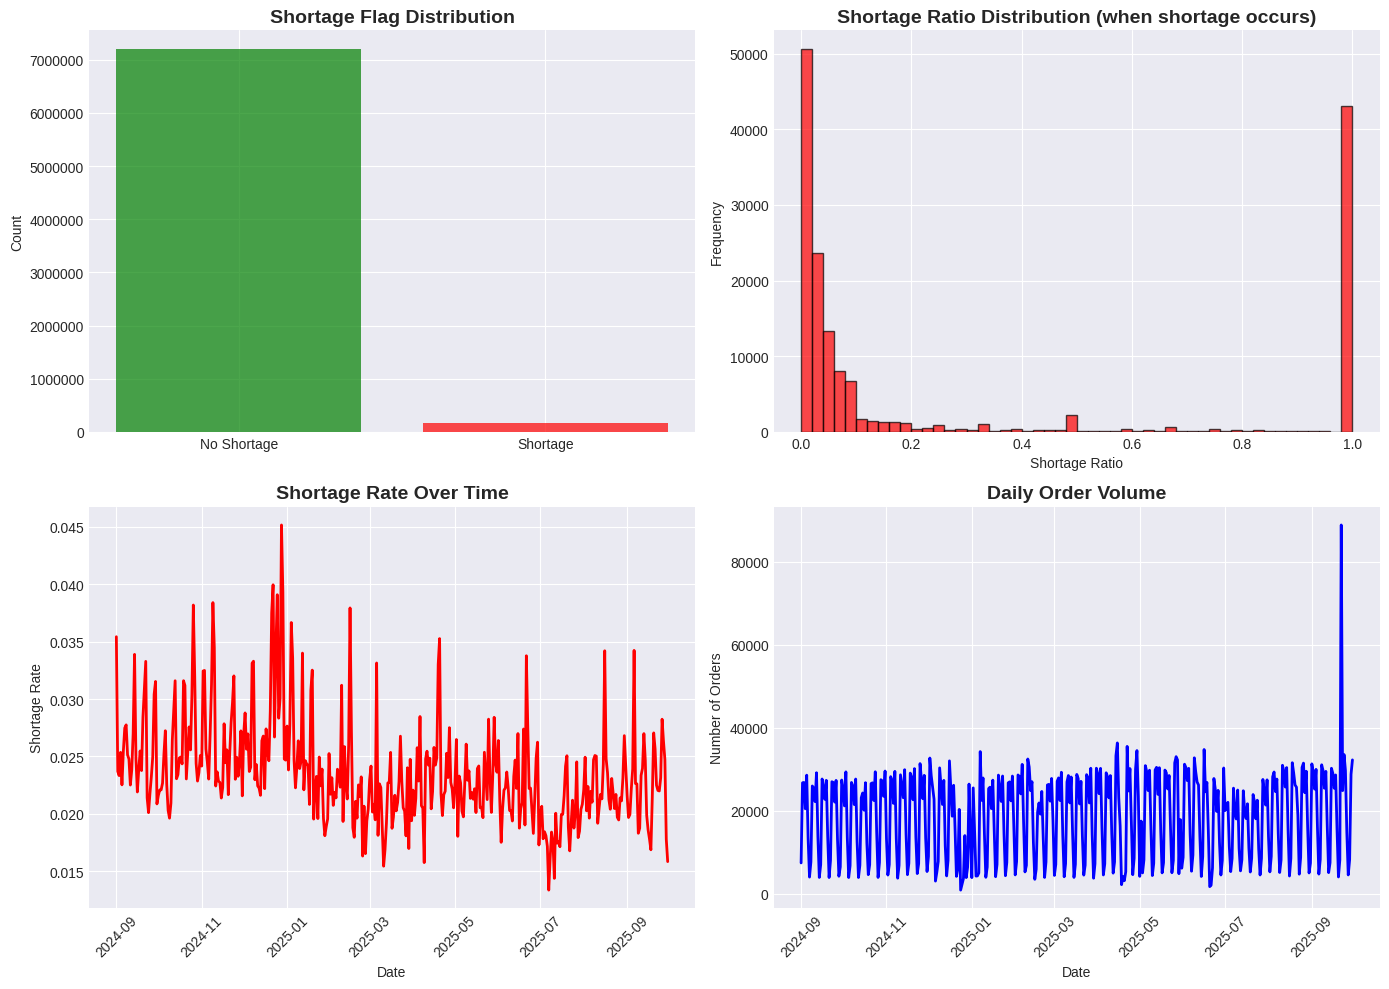


Class imbalance ratio: 43.65:1 (no shortage : shortage)


In [13]:
# Visualize shortage distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Shortage flag distribution
axes[0, 0].bar(['No Shortage', 'Shortage'],
               [(sales_df['shortage_flag']==0).sum(), sales_df['shortage_flag'].sum()],
               color=['green', 'red'], alpha=0.7)
axes[0, 0].set_title('Shortage Flag Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Count')
axes[0, 0].ticklabel_format(style='plain', axis='y')

# Shortage ratio distribution
axes[0, 1].hist(sales_df[sales_df['shortage_flag']==1]['shortage_ratio'],
                bins=50, color='red', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Shortage Ratio Distribution (when shortage occurs)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Shortage Ratio')
axes[0, 1].set_ylabel('Frequency')

# Shortage rate over time
shortage_by_date = sales_df.groupby('order_created_date')['shortage_flag'].agg(['mean', 'count']).reset_index()
axes[1, 0].plot(shortage_by_date['order_created_date'], shortage_by_date['mean'], color='red', linewidth=2)
axes[1, 0].set_title('Shortage Rate Over Time', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Shortage Rate')
axes[1, 0].tick_params(axis='x', rotation=45)

# Order count over time
axes[1, 1].plot(shortage_by_date['order_created_date'], shortage_by_date['count'], color='blue', linewidth=2)
axes[1, 1].set_title('Daily Order Volume', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Number of Orders')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"\nClass imbalance ratio: {(1-sales_df['shortage_flag'].mean())/sales_df['shortage_flag'].mean():.2f}:1 (no shortage : shortage)")


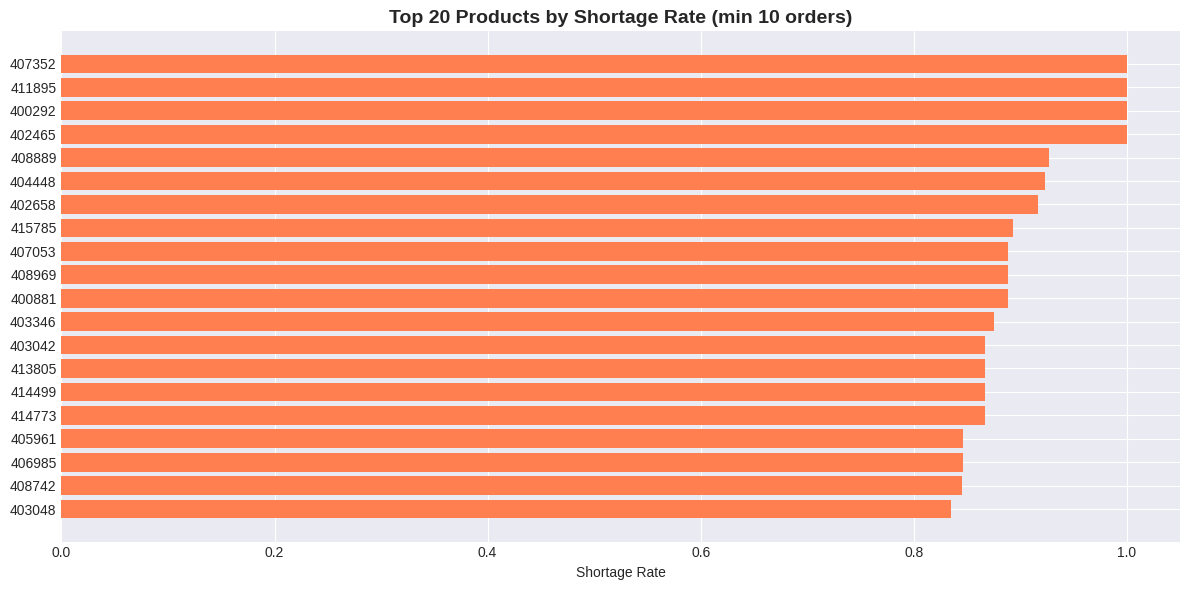

In [14]:
# Analyze shortage by top products
top_products_shortage = sales_df.groupby('product_code').agg({
    'shortage_flag': ['sum', 'mean', 'count']
}).reset_index()
top_products_shortage.columns = ['product_code', 'total_shortages', 'shortage_rate', 'order_count']
top_products_shortage = top_products_shortage[top_products_shortage['order_count'] >= 10]  # Min 10 orders
top_products_shortage = top_products_shortage.sort_values('shortage_rate', ascending=False).head(20)

fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(range(len(top_products_shortage)), top_products_shortage['shortage_rate'], color='coral')
ax.set_yticks(range(len(top_products_shortage)))
ax.set_yticklabels(top_products_shortage['product_code'])
ax.set_xlabel('Shortage Rate')
ax.set_title('Top 20 Products by Shortage Rate (min 10 orders)', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()


## 3. Feature Engineering


In [15]:
# Create a copy for feature engineering
df = sales_df.copy()

# Sort by date to ensure temporal ordering
df = df.sort_values('order_created_date').reset_index(drop=True)

print(f"Working dataset: {len(df):,} rows")
print(f"Date range: {df['order_created_date'].min()} to {df['order_created_date'].max()}")


Working dataset: 7,357,509 rows
Date range: 2024-09-01 00:00:00 to 2025-09-30 00:00:00


### 3.1 Line-Level Features


In [16]:
# Line-level features
df['lead_time_days'] = (df['requested_delivery_date'] - df['order_created_date']).dt.days

# Temporal features
df['order_dayofweek'] = df['order_created_date'].dt.dayofweek
df['order_month'] = df['order_created_date'].dt.month
df['order_day'] = df['order_created_date'].dt.day
df['order_week'] = df['order_created_date'].dt.isocalendar().week
df['is_weekend'] = (df['order_dayofweek'] >= 5).astype(int)

# Already have order_qty which is a direct feature
df['ordered_qty'] = df['order_qty']

print("Line-level features created:")
print("- lead_time_days")
print("- ordered_qty")
print("- order_dayofweek, order_month, order_day, order_week")
print("- is_weekend")


Line-level features created:
- lead_time_days
- ordered_qty
- order_dayofweek, order_month, order_day, order_week
- is_weekend


In [18]:
# Rolling features - VECTORIZED (100x+ faster than iterrows)
def add_rolling_features(df, group_col, windows=[7, 30, 90]):
    """
    Ultra-fast vectorized rolling features using groupby + rolling.
    This replaces the slow iterrows() approach with pure pandas operations.
    """
    print(f"\nComputing rolling features for {group_col}...")
    start = time.time()

    # Sort by group and date
    df = df.sort_values([group_col, 'order_created_date'])
    grouped = df.groupby(group_col)

    prefix = group_col.replace('_number', '').replace('_code', '')

    for window in windows:
        print(f"  Processing {window}-day window...", end='')
        window_start = time.time()

        # Shift to exclude current row (prevent data leakage)
        shifted_shortage = grouped['shortage_flag'].shift(1)
        shifted_delivered = grouped['delivered_qty'].shift(1)
        shifted_ordered = grouped['order_qty'].shift(1)

        # Rolling computations - vectorized!
        # Shortage rate
        df[f'{prefix}_shortage_rate_{window}d'] = (
            shifted_shortage.groupby(df[group_col])
            .rolling(window=window, min_periods=1).mean()
            .reset_index(level=0, drop=True).fillna(0)
        )

        # Fill rate (delivered / ordered)
        delivered_sum = (
            shifted_delivered.groupby(df[group_col])
            .rolling(window=window, min_periods=1).sum()
            .reset_index(level=0, drop=True)
        )
        ordered_sum = (
            shifted_ordered.groupby(df[group_col])
            .rolling(window=window, min_periods=1).sum()
            .reset_index(level=0, drop=True)
        )
        df[f'{prefix}_fill_rate_{window}d'] = (delivered_sum / ordered_sum).fillna(1.0).clip(0, 1)

        # Order frequency
        df[f'{prefix}_order_frequency_{window}d'] = (
            shifted_shortage.groupby(df[group_col])
            .rolling(window=window, min_periods=1).count()
            .reset_index(level=0, drop=True).fillna(0).astype(int)
        )

        # Average order quantity (for SKU)
        if prefix == 'sku':
            df[f'{prefix}_avg_order_qty_{window}d'] = (
                shifted_ordered.groupby(df[group_col])
                .rolling(window=window, min_periods=1).mean()
                .reset_index(level=0, drop=True).fillna(0)
            )

        # Basket size (for customer)
        if prefix == 'customer':
            # Unique order count in window
            order_counts = (
                grouped['order_number'].shift(1)
                .groupby(df[group_col])
                .rolling(window=window, min_periods=1)
                .apply(lambda x: x.nunique() if len(x) > 0 else 0, raw=False)
                .reset_index(level=0, drop=True)
            )
            freq = df[f'{prefix}_order_frequency_{window}d']
            df[f'{prefix}_avg_basket_size_{window}d'] = (freq / order_counts.replace(0, 1)).fillna(0)

        print(f" Done in {time.time()-window_start:.1f}s")

    print(f"  ✓ Total time: {time.time()-start:.2f}s")
    return df



In [19]:

# Add SKU features
df = add_rolling_features(df, 'product_code', windows=[7, 30, 90])

# Add Customer features
df = add_rolling_features(df, 'customer_number', windows=[7, 30, 90])


Computing rolling features for product_code...
  Processing 7-day window... Done in 14.2s
  Processing 30-day window... Done in 14.0s
  Processing 90-day window... Done in 14.0s
  ✓ Total time: 45.49s

Computing rolling features for customer_number...
  Processing 7-day window... Done in 466.7s
  Processing 30-day window... Done in 456.3s
  Processing 90-day window... Done in 457.7s
  ✓ Total time: 1385.03s


In [22]:

# Supplier features (from purchase data)
print("\nComputing supplier features...")
start = time.time()

purchases = purchases_df.sort_values(['product_code', 'po_created_date']).copy()
grouped = purchases.groupby('product_code')

for window in [7, 30, 90]:
    # Rolling supplier metrics
    delivered_sum = (
        grouped['received_qty'].shift(1)
        .groupby(purchases['product_code'])
        .rolling(window=window, min_periods=1).sum()
        .reset_index(level=0, drop=True)
    )
    ordered_sum = (
        grouped['ordered_qty'].shift(1)
        .groupby(purchases['product_code'])
        .rolling(window=window, min_periods=1).sum()
        .reset_index(level=0, drop=True)
    )
    volatility = (
        grouped['received_qty'].shift(1)
        .groupby(purchases['product_code'])
        .rolling(window=window, min_periods=1).std()
        .reset_index(level=0, drop=True).fillna(0)
    )
    count = (
        grouped['received_qty'].shift(1)
        .groupby(purchases['product_code'])
        .rolling(window=window, min_periods=1).count()
        .reset_index(level=0, drop=True)
    )

    purchases[f'supplier_fill_rate_{window}d'] = (delivered_sum / ordered_sum).fillna(1.0).clip(0, 1)
    purchases[f'supplier_order_volatility_{window}d'] = volatility
    purchases[f'supplier_order_count_{window}d'] = count.astype(int)

# Merge with sales
feature_cols = [c for c in purchases.columns if c.startswith('supplier_')]
merge_df = purchases[['product_code', 'po_created_date'] + feature_cols]

df = pd.merge_asof(
    df.sort_values('order_created_date'),
    merge_df.sort_values('po_created_date').drop_duplicates(['product_code', 'po_created_date'], keep='last'),
    left_on='order_created_date',
    right_on='po_created_date',
    by='product_code',
    direction='backward'
)



Computing supplier features...


In [23]:

# Fill missing supplier features
for col in feature_cols:
    if 'fill_rate' in col:
        df[col] = df[col].fillna(1.0)
    else:
        df[col] = df[col].fillna(0)

print(f"  ✓ Supplier features added in {time.time()-start:.2f}s")

# Replacement features
print("\nComputing replacement features...")
start = time.time()

for entity, col in [('sku', 'product_code'), ('customer', 'customer_number')]:
    repl_counts = (
        replacement_df.groupby([col, 'order_created_date'])
        .size().reset_index(name='count')
        .sort_values([col, 'order_created_date'])
    )

    for window in [7, 30, 90]:
        repl_counts[f'temp_{window}'] = (
            repl_counts.groupby(col)['count']
            .rolling(window=window, min_periods=1).sum()
            .reset_index(level=0, drop=True)
        )

        df = pd.merge_asof(
            df.sort_values('order_created_date'),
            repl_counts[[col, 'order_created_date', f'temp_{window}']].sort_values('order_created_date'),
            on='order_created_date',
            by=col,
            direction='backward'
        )

        df.rename(columns={f'temp_{window}': f'{entity}_replacement_count_{window}d'}, inplace=True)
        df[f'{entity}_replacement_count_{window}d'] = df[f'{entity}_replacement_count_{window}d'].fillna(0).astype(int)

print(f"  ✓ Replacement features added in {time.time()-start:.2f}s")

print("\n" + "="*80)
print(f"FEATURE ENGINEERING COMPLETE")
print(f"Total features: {df.shape[1]}")
print("="*80)


  ✓ Supplier features added in 13.65s

Computing replacement features...
  ✓ Replacement features added in 30.45s

FEATURE ENGINEERING COMPLETE
Total features: 64


In [20]:
# Some sanity checks:

In [21]:
print("\n" + "="*80)
print("DATASET OVERVIEW AFTER FEATURE ENGINEERING")
print("="*80)

print(f"Rows: {df.shape[0]:,}")
print(f"Columns: {df.shape[1]:,}")

mem_gb = df.memory_usage(deep=True).sum() / 1e9
print(f"Approx. memory usage: {mem_gb:.2f} GB")

print("\nDate range (orders):")
print(f"- Min order_created_date: {df['order_created_date'].min()}")
print(f"- Max order_created_date: {df['order_created_date'].max()}")

print("\nSample columns:")
print(df.columns[:40])



DATASET OVERVIEW AFTER FEATURE ENGINEERING
Rows: 7,357,509
Columns: 48
Approx. memory usage: 3.09 GB

Date range (orders):
- Min order_created_date: 2024-09-01 00:00:00
- Max order_created_date: 2025-09-30 00:00:00

Sample columns:
Index(['order_number', 'order_created_date', 'order_created_time',
       'requested_delivery_date', 'customer_number', 'order_row_number',
       'product_code', 'order_qty', 'sales_unit', 'delivery_number', 'plant',
       'storage_location', 'delivered_qty', 'transfer_number',
       'warehouse_number', 'picking_confirmed_date', 'picking_confirmed_time',
       'picking_picked_qty', 'shortage_flag', 'shortage_ratio',
       'lead_time_days', 'order_dayofweek', 'order_month', 'order_day',
       'order_week', 'is_weekend', 'ordered_qty', 'product_shortage_rate_7d',
       'product_fill_rate_7d', 'product_order_frequency_7d',
       'product_shortage_rate_30d', 'product_fill_rate_30d',
       'product_order_frequency_30d', 'product_shortage_rate_90d',
    

In [24]:
# Group engineered columns by prefix
sku_cols = [c for c in df.columns if c.startswith('sku_')]
customer_cols = [c for c in df.columns if c.startswith('customer_')]
supplier_cols = [c for c in df.columns if c.startswith('supplier_')]
replacement_cols = [c for c in df.columns if 'replacement_count' in c]

print("\nEngineered feature groups:")
print(f"- SKU cols:       {len(sku_cols)}")
print(f"- Customer cols:  {len(customer_cols)}")
print(f"- Supplier cols:  {len(supplier_cols)}")
print(f"- Replacement cols:{len(replacement_cols)}")

print("\nExample SKU cols:", sku_cols[:8])
print("Example customer cols:", customer_cols[:8])
print("Example supplier cols:", supplier_cols[:8])
print("Example replacement cols:", replacement_cols[:8])



Engineered feature groups:
- SKU cols:       3
- Customer cols:  16
- Supplier cols:  9
- Replacement cols:6

Example SKU cols: ['sku_replacement_count_7d', 'sku_replacement_count_30d', 'sku_replacement_count_90d']
Example customer cols: ['customer_number', 'customer_shortage_rate_7d', 'customer_fill_rate_7d', 'customer_order_frequency_7d', 'customer_avg_basket_size_7d', 'customer_shortage_rate_30d', 'customer_fill_rate_30d', 'customer_order_frequency_30d']
Example supplier cols: ['supplier_fill_rate_7d', 'supplier_order_volatility_7d', 'supplier_order_count_7d', 'supplier_fill_rate_30d', 'supplier_order_volatility_30d', 'supplier_order_count_30d', 'supplier_fill_rate_90d', 'supplier_order_volatility_90d']
Example replacement cols: ['sku_replacement_count_7d', 'sku_replacement_count_30d', 'sku_replacement_count_90d', 'customer_replacement_count_7d', 'customer_replacement_count_30d', 'customer_replacement_count_90d']


In [25]:
print("\n" + "="*80)
print("MISSING VALUE RATES IN ENGINEERED FEATURES (TOP 20)")
print("="*80)

engineered_cols = sku_cols + customer_cols + supplier_cols + replacement_cols
na_rates = df[engineered_cols].isna().mean().sort_values(ascending=False)
print(na_rates.head(20))



MISSING VALUE RATES IN ENGINEERED FEATURES (TOP 20)
sku_replacement_count_7d          0.0
sku_replacement_count_30d         0.0
sku_replacement_count_90d         0.0
customer_number                   0.0
customer_shortage_rate_7d         0.0
customer_fill_rate_7d             0.0
customer_order_frequency_7d       0.0
customer_avg_basket_size_7d       0.0
customer_shortage_rate_30d        0.0
customer_fill_rate_30d            0.0
customer_order_frequency_30d      0.0
customer_avg_basket_size_30d      0.0
customer_shortage_rate_90d        0.0
customer_fill_rate_90d            0.0
customer_order_frequency_90d      0.0
customer_avg_basket_size_90d      0.0
customer_replacement_count_7d     0.0
customer_replacement_count_30d    0.0
customer_replacement_count_90d    0.0
supplier_fill_rate_7d             0.0
dtype: float64



product_ cols: ['product_code', 'product_shortage_rate_7d', 'product_fill_rate_7d', 'product_order_frequency_7d', 'product_shortage_rate_30d', 'product_fill_rate_30d', 'product_order_frequency_30d', 'product_shortage_rate_90d', 'product_fill_rate_90d', 'product_order_frequency_90d']

customer_ cols: ['customer_number', 'customer_shortage_rate_7d', 'customer_fill_rate_7d', 'customer_order_frequency_7d', 'customer_avg_basket_size_7d', 'customer_shortage_rate_30d', 'customer_fill_rate_30d', 'customer_order_frequency_30d', 'customer_avg_basket_size_30d', 'customer_shortage_rate_90d', 'customer_fill_rate_90d', 'customer_order_frequency_90d', 'customer_avg_basket_size_90d', 'customer_replacement_count_7d', 'customer_replacement_count_30d', 'customer_replacement_count_90d']

supplier_ cols: ['supplier_fill_rate_7d', 'supplier_order_volatility_7d', 'supplier_order_count_7d', 'supplier_fill_rate_30d', 'supplier_order_volatility_30d', 'supplier_order_count_30d', 'supplier_fill_rate_90d', 'suppl

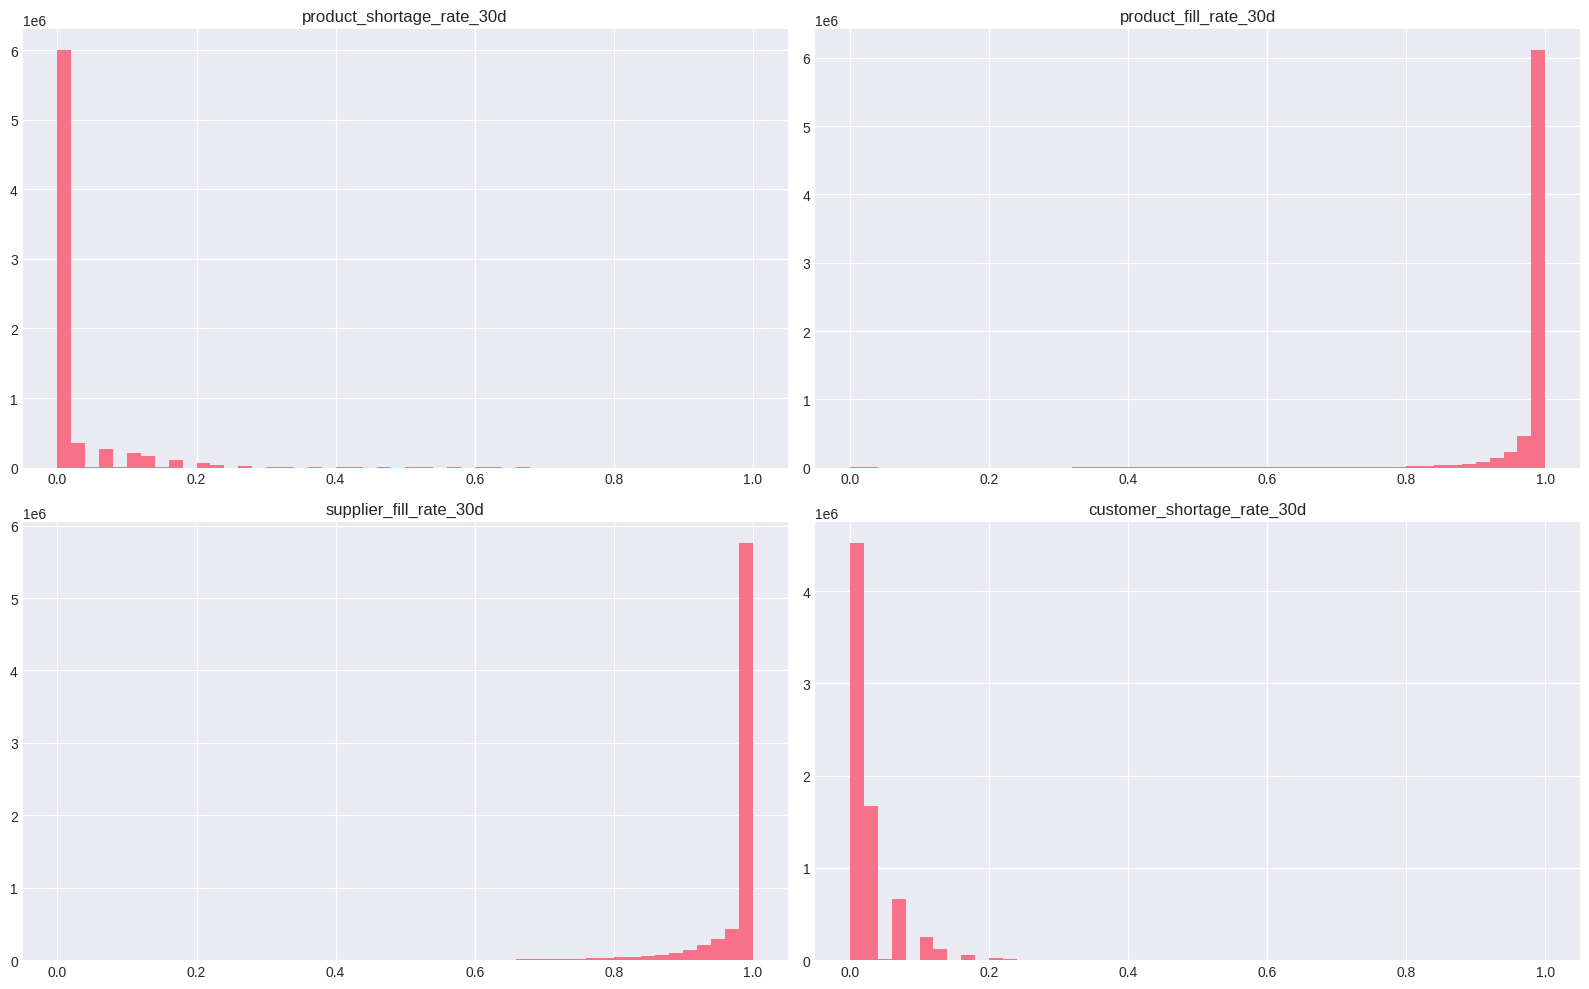

<Figure size 800x500 with 0 Axes>

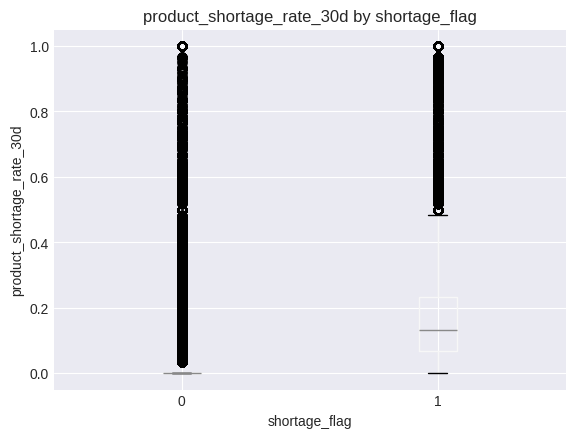

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1.1: See all product_ / customer_ / supplier_ columns ---

product_cols = [c for c in df.columns if c.startswith('product_')]
customer_cols = [c for c in df.columns if c.startswith('customer_')]
supplier_cols = [c for c in df.columns if c.startswith('supplier_')]

print("\nproduct_ cols:", product_cols)
print("\ncustomer_ cols:", customer_cols)
print("\nsupplier_ cols:", supplier_cols)

# --- 1.2: Descriptive stats for some key features ---

key_num_features = [
    'product_shortage_rate_30d',
    'product_fill_rate_30d',
    'customer_shortage_rate_30d',
    'customer_fill_rate_30d',
    'supplier_fill_rate_30d',
    'sku_replacement_count_30d',
    'customer_replacement_count_30d'
]

# Keep only those that actually exist
key_num_features = [c for c in key_num_features if c in df.columns]

print("\nDescriptive stats for key features:")
print(df[key_num_features].describe(percentiles=[0.01, 0.5, 0.99]).T)

# --- 1.3: Simple distributions for a few important features ---

plt.figure(figsize=(16, 10))

plot_features = []
if 'product_shortage_rate_30d' in df.columns:
    plot_features.append('product_shortage_rate_30d')
if 'product_fill_rate_30d' in df.columns:
    plot_features.append('product_fill_rate_30d')
if 'supplier_fill_rate_30d' in df.columns:
    plot_features.append('supplier_fill_rate_30d')
if 'customer_shortage_rate_30d' in df.columns:
    plot_features.append('customer_shortage_rate_30d')

for i, feat in enumerate(plot_features, 1):
    plt.subplot(2, 2, i)
    df[feat].hist(bins=50)
    plt.title(feat)

plt.tight_layout()
plt.show()

# --- 1.4: One feature vs target ---

if 'product_shortage_rate_30d' in df.columns:
    plt.figure(figsize=(8, 5))
    df.boxplot(column='product_shortage_rate_30d', by='shortage_flag')
    plt.title('product_shortage_rate_30d by shortage_flag')
    plt.suptitle('')
    plt.xlabel('shortage_flag')
    plt.ylabel('product_shortage_rate_30d')
    plt.show()


In [29]:
df = df.sort_values('order_created_date').reset_index(drop=True)

print("\nCreating time-based split...")



Creating time-based split...


In [30]:
n_samples = len(df)
train_size = int(0.70 * n_samples)
val_size = int(0.15 * n_samples)

train_df = df.iloc[:train_size].copy()
val_df = df.iloc[train_size:train_size + val_size].copy()
test_df = df.iloc[train_size + val_size:].copy()

print(f"✓ Train: {len(train_df):,} | Val: {len(val_df):,} | Test: {len(test_df):,}")

# Define features
exclude_cols = [
    'order_number', 'order_created_date', 'order_created_time', 'requested_delivery_date',
    'customer_number', 'order_row_number', 'product_code', 'order_qty', 'sales_unit',
    'delivery_number', 'plant', 'storage_location', 'delivered_qty', 'transfer_number',
    'warehouse_number', 'picking_confirmed_date', 'picking_confirmed_time', 'picking_picked_qty',
    'shortage_flag', 'shortage_ratio', 'po_created_date'
]

feature_cols = [col for col in df.columns if col not in exclude_cols]
cat_cols = [c for c in ['product_code', 'customer_number', 'plant', 'storage_location'] if c in df.columns]

# Target encoding (slightly stronger smoothing)
print("Applying target encoding...")
target_encoder = TargetEncoder(cols=cat_cols, smoothing=10.0)
target_encoder.fit(train_df[cat_cols], train_df['shortage_flag'])

train_df[cat_cols] = target_encoder.transform(train_df[cat_cols])
val_df[cat_cols] = target_encoder.transform(val_df[cat_cols])
test_df[cat_cols] = target_encoder.transform(test_df[cat_cols])

# Prepare arrays
all_features = feature_cols + cat_cols
X_train = train_df[all_features]
y_train = train_df['shortage_flag']
X_val = val_df[all_features]
y_val = val_df['shortage_flag']
X_test = test_df[all_features]
y_test = test_df['shortage_flag']

print(f"✓ Feature matrix: {X_train.shape}")

✓ Train: 5,150,256 | Val: 1,103,626 | Test: 1,103,627
Applying target encoding...
✓ Feature matrix: (5150256, 47)


In [33]:
# ============================================================================
# MODEL TRAINING
# ============================================================================
print("\n" + "="*80)
print("TRAINING LIGHTGBM MODEL")
print("="*80)

n_positive = y_train.sum()
n_negative = len(y_train) - n_positive
scale_pos_weight = n_negative / n_positive

# Parameters
params = {
    'objective': 'binary',
    'metric': ['auc', 'average_precision'],
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'max_depth': 7,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'scale_pos_weight': scale_pos_weight,
    'verbose': -1,
    'random_state': 42
}

# Enable GPU if available
if GPU_AVAILABLE:
    params['device_type'] = 'gpu'
    params['device'] = 'gpu'
    params['gpu_platform_id'] = 0
    params['gpu_device_id'] = 0
    print("⚡ GPU ACCELERATION ENABLED\n")
else:
    params['device'] = 'cpu'
    print("Using CPU\n")

# Create datasets
train_data = lgb.Dataset(X_train, label=y_train, feature_name=all_features)
val_data = lgb.Dataset(X_val, label=y_val, feature_name=all_features, reference=train_data)

# Train
print("Training...")
start = time.time()

model = lgb.train(
    params,
    train_data,
    num_boost_round=500,
    valid_sets=[val_data, train_data],
    valid_names=['valid', 'train'],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=50)]
)

train_time = time.time() - start
print(f"\n✓ Training completed in {train_time:.2f}s")
print(f"  Best iteration: {model.best_iteration}")


TRAINING LIGHTGBM MODEL
⚡ GPU ACCELERATION ENABLED

Training...
Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.946151	train's average_precision: 0.341496	valid's auc: 0.931452	valid's average_precision: 0.317679
[100]	train's auc: 0.947432	train's average_precision: 0.361463	valid's auc: 0.928981	valid's average_precision: 0.332084
Early stopping, best iteration is:
[52]	train's auc: 0.946234	train's average_precision: 0.342262	valid's auc: 0.931582	valid's average_precision: 0.31857

✓ Training completed in 104.77s
  Best iteration: 52


In [35]:
#======================
#Improving Hyperparams
#=====================


import numpy as np
import lightgbm as lgb
import time
from sklearn.metrics import roc_auc_score, average_precision_score
# ============================================================================
# 1. BUILD A SMALLER TUNING SET (KEEP ALL POSITIVES + SAMPLE NEGATIVES)
# ============================================================================
print("\n" + "="*80)
print("BUILDING TUNING SUBSET")
print("="*80)

# Start from train_df to keep consistency with target encoding already applied
tune_df = train_df.copy()

pos_mask = tune_df['shortage_flag'] == 1
neg_mask = ~pos_mask

n_pos = pos_mask.sum()
n_neg = neg_mask.sum()

print(f"Positives in full train: {n_pos:,}")
print(f"Negatives in full train: {n_neg:,}")

# Target size for tuning set (you can adjust 500_000 up/down)
target_tune_size = 500_000

# Keep all positives, sample negatives
n_neg_tune = max(0, min(n_neg, target_tune_size - n_pos))

tune_pos = tune_df.loc[pos_mask]
tune_neg = tune_df.loc[neg_mask].sample(n=n_neg_tune, random_state=42)

tune_df = pd.concat([tune_pos, tune_neg]).sample(frac=1.0, random_state=42)  # shuffle

X_tune = tune_df[all_features]
y_tune = tune_df['shortage_flag'].astype(int)

print(f"Tuning set size: {X_tune.shape[0]:,} rows, {X_tune.shape[1]} features")
print(f"Positive ratio in tuning set: {y_tune.mean():.4f}")


BUILDING TUNING SUBSET
Positives in full train: 119,032
Negatives in full train: 5,031,224
Tuning set size: 500,000 rows, 47 features
Positive ratio in tuning set: 0.2381


In [36]:
# ============================================================================
# 2. DEFINE A SMALL HYPERPARAMETER GRID
# ============================================================================
print("\n" + "="*80)
print("HYPERPARAMETER SEARCH (SMALL GRID)")
print("="*80)

pos_ratio = y_tune.mean()
base_scale_pos_weight = (1 - pos_ratio) / pos_ratio

param_grid = [
    {
        "num_leaves": 31,
        "max_depth": 7,
        "min_data_in_leaf": 200,
        "feature_fraction": 0.8,
        "bagging_fraction": 0.8,
        "bagging_freq": 5,
        "scale_pos_weight": base_scale_pos_weight * 0.7,
    },
    {
        "num_leaves": 63,
        "max_depth": 9,
        "min_data_in_leaf": 200,
        "feature_fraction": 0.8,
        "bagging_fraction": 0.8,
        "bagging_freq": 5,
        "scale_pos_weight": base_scale_pos_weight,
    },
    {
        "num_leaves": 63,
        "max_depth": -1,
        "min_data_in_leaf": 400,
        "feature_fraction": 0.9,
        "bagging_fraction": 0.9,
        "bagging_freq": 3,
        "scale_pos_weight": base_scale_pos_weight * 0.7,
    },
    {
        "num_leaves": 127,
        "max_depth": -1,
        "min_data_in_leaf": 600,
        "feature_fraction": 0.9,
        "bagging_fraction": 0.8,
        "bagging_freq": 3,
        "scale_pos_weight": base_scale_pos_weight,
    },
]

base_params = {
    "objective": "binary",
    "metric": ["auc", "average_precision"],
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "verbose": -1,
    "random_state": 42,
}

if GPU_AVAILABLE:
    base_params["device_type"] = "gpu"
    base_params["gpu_platform_id"] = 0
    base_params["gpu_device_id"] = 0
    print("⚡ Using GPU for tuning")
else:
    base_params["device_type"] = "cpu"
    print("Using CPU for tuning")

# LightGBM datasets for tuning
tune_train_data = lgb.Dataset(X_tune, label=y_tune, feature_name=all_features)
tune_val_data = lgb.Dataset(X_val, label=y_val, feature_name=all_features, reference=tune_train_data)

best_auc = -np.inf
best_ap = -np.inf
best_iter = None
best_params_full = None
best_model_tune = None

for i, pg in enumerate(param_grid):
    print(f"\n--- Config {i+1}/{len(param_grid)} ---")
    params = base_params.copy()
    params.update(pg)
    print("Params:", params)

    start_t = time.time()
    model_tmp = lgb.train(
        params,
        tune_train_data,
        num_boost_round=400,
        valid_sets=[tune_val_data],
        valid_names=["valid"],
        callbacks=[
            lgb.early_stopping(stopping_rounds=40),
            lgb.log_evaluation(period=50)
        ]
    )
    elapsed = time.time() - start_t
    print(f"Config {i+1} training time: {elapsed:.1f}s")

    # Evaluate on validation
    y_val_proba = model_tmp.predict(X_val, num_iteration=model_tmp.best_iteration)
    auc = roc_auc_score(y_val, y_val_proba)
    ap = average_precision_score(y_val, y_val_proba)

    print(f"Validation AUC: {auc:.4f}, PR-AUC: {ap:.4f}, best_iter: {model_tmp.best_iteration}")

    if auc > best_auc:
        best_auc = auc
        best_ap = ap
        best_iter = model_tmp.best_iteration
        best_params_full = params
        best_model_tune = model_tmp

print("\n" + "="*80)
print("BEST CONFIG FROM TUNING")
print("="*80)
print("Best AUC:", best_auc)
print("Best PR-AUC:", best_ap)
print("Best iteration:", best_iter)
print("Best params:")
for k, v in best_params_full.items():
    print(f"  {k}: {v}")


HYPERPARAMETER SEARCH (SMALL GRID)
⚡ Using GPU for tuning

--- Config 1/4 ---
Params: {'objective': 'binary', 'metric': ['auc', 'average_precision'], 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'verbose': -1, 'random_state': 42, 'device_type': 'gpu', 'gpu_platform_id': 0, 'gpu_device_id': 0, 'num_leaves': 31, 'max_depth': 7, 'min_data_in_leaf': 200, 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'scale_pos_weight': np.float64(2.240385778614154)}
Training until validation scores don't improve for 40 rounds
[50]	valid's auc: 0.933754	valid's average_precision: 0.315744
Early stopping, best iteration is:
[20]	valid's auc: 0.934339	valid's average_precision: 0.29092
Config 1 training time: 7.6s
Validation AUC: 0.9343, PR-AUC: 0.2909, best_iter: 20

--- Config 2/4 ---
Params: {'objective': 'binary', 'metric': ['auc', 'average_precision'], 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'verbose': -1, 'random_state': 42, 'device_type': 'gpu', 'gpu_platform_id': 0, 

In [38]:
# Trian best config:

import numpy as np
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_score, recall_score, precision_recall_curve,
    classification_report
)
import lightgbm as lgb
import matplotlib.pyplot as plt

print("\n" + "="*80)
print("TRAINING FINAL MODEL (BEST CONFIG FROM TUNING - CONFIG 4)")
print("="*80)

# Best config from tuning (CONFIG 4)
best_params_final = {
    "objective": "binary",
    "metric": ["auc", "average_precision"],
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "verbose": -1,
    "random_state": 42,
    "num_leaves": 127,
    "max_depth": -1,
    "min_data_in_leaf": 600,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 3,
    "scale_pos_weight": 3.2005511123059343  # from tuning output
}

if GPU_AVAILABLE:
    best_params_final["device_type"] = "gpu"
    best_params_final["gpu_platform_id"] = 0
    best_params_final["gpu_device_id"] = 0
    print("⚡ GPU ENABLED FOR FINAL TRAINING")
else:
    best_params_final["device_type"] = "cpu"
    print("Using CPU for final training")

# LightGBM datasets
final_train_data = lgb.Dataset(X_train, label=y_train, feature_name=all_features)
final_val_data = lgb.Dataset(X_val, label=y_val, feature_name=all_features, reference=final_train_data)

# We saw best_iter ~34 in tuning; allow a bit more, early stopping will cut
num_boost_round_estimate = int(34 * 1.5)

print(f"\nEstimated num_boost_round: {num_boost_round_estimate}")

start = time.time()
final_model = lgb.train(
    best_params_final,
    final_train_data,
    num_boost_round=num_boost_round_estimate,
    valid_sets=[final_val_data, final_train_data],
    valid_names=["valid", "train"],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=50)
    ]
)
train_time = time.time() - start

print(f"\n✓ Final model training completed in {train_time:.1f}s")
print(f"  Best iteration (final model): {final_model.best_iteration}")


TRAINING FINAL MODEL (BEST CONFIG FROM TUNING - CONFIG 4)
⚡ GPU ENABLED FOR FINAL TRAINING

Estimated num_boost_round: 51
Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.950678	train's average_precision: 0.383809	valid's auc: 0.935436	valid's average_precision: 0.344213
Did not meet early stopping. Best iteration is:
[34]	train's auc: 0.949592	train's average_precision: 0.37928	valid's auc: 0.936155	valid's average_precision: 0.344929

✓ Final model training completed in 53.8s
  Best iteration (final model): 34



EVALUATION @ DEFAULT THRESHOLD 0.50

Validation metrics @ threshold=0.50:
  ROC-AUC: 0.9362
  PR-AUC:  0.3449
  F1:      0.2924
  Precision: 0.5284
  Recall:    0.2021

Classification report:
              precision    recall  f1-score   support

           0     0.9839    0.9963    0.9900   1081464
           1     0.5284    0.2021    0.2924     22162

    accuracy                         0.9804   1103626
   macro avg     0.7561    0.5992    0.6412   1103626
weighted avg     0.9747    0.9804    0.9760   1103626


Test metrics @ threshold=0.50:
  ROC-AUC: 0.9402
  PR-AUC:  0.3888
  F1:      0.3355
  Precision: 0.5804
  Recall:    0.2359

Classification report:
              precision    recall  f1-score   support

           0     0.9835    0.9963    0.9899   1080031
           1     0.5804    0.2359    0.3355     23596

    accuracy                         0.9800   1103627
   macro avg     0.7820    0.6161    0.6627   1103627
weighted avg     0.9749    0.9800    0.9759   1103627


TH

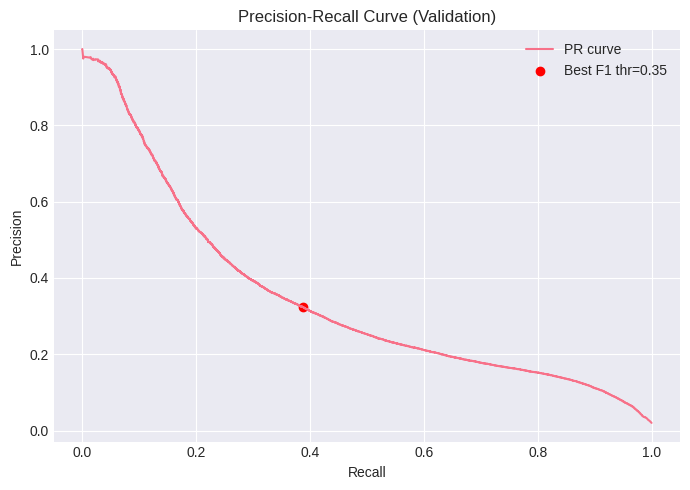

In [39]:
# ============================================================================
# 2. EVALUATE FINAL MODEL ON VAL + TEST (AUC, PR-AUC, METRICS)
# ============================================================================

def evaluate_split(name, model, X_split, y_split, threshold=0.5):
    y_proba = model.predict(X_split, num_iteration=model.best_iteration)
    y_pred = (y_proba >= threshold).astype(int)

    auc = roc_auc_score(y_split, y_proba)
    ap = average_precision_score(y_split, y_proba)
    f1 = f1_score(y_split, y_pred, zero_division=0)
    prec = precision_score(y_split, y_pred, zero_division=0)
    rec = recall_score(y_split, y_pred, zero_division=0)

    print(f"\n{name} metrics @ threshold={threshold:.2f}:")
    print(f"  ROC-AUC: {auc:.4f}")
    print(f"  PR-AUC:  {ap:.4f}")
    print(f"  F1:      {f1:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")

    print("\nClassification report:")
    print(classification_report(y_split, y_pred, digits=4, zero_division=0))

    return y_proba

print("\n" + "="*80)
print("EVALUATION @ DEFAULT THRESHOLD 0.50")
print("="*80)

val_proba = evaluate_split("Validation", final_model, X_val, y_val, threshold=0.5)
test_proba = evaluate_split("Test", final_model, X_test, y_test, threshold=0.5)

# ============================================================================
#  FIND BETTER THRESHOLD (MAX F1 ON VALIDATION)
# ============================================================================

print("\n" + "="*80)
print("THRESHOLD OPTIMIZATION (MAX F1 ON VALIDATION)")
print("="*80)

precisions, recalls, thresholds = precision_recall_curve(y_val, val_proba)

# Avoid the first point (threshold undefined); compute F1 for each threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
best_idx = np.nanargmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]
best_prec = precisions[best_idx]
best_rec = recalls[best_idx]

print(f"Best threshold on Validation (by F1): {best_threshold:.4f}")
print(f"  F1:        {best_f1:.4f}")
print(f"  Precision: {best_prec:.4f}")
print(f"  Recall:    {best_rec:.4f}")

# Evaluate again with this threshold
print("\n" + "="*80)
print("EVALUATION @ BEST F1 THRESHOLD (FROM VALIDATION)")
print("="*80)

_ = evaluate_split("Validation (best-F1 thr)", final_model, X_val, y_val, threshold=best_threshold)
_ = evaluate_split("Test (best-F1 thr)", final_model, X_test, y_test, threshold=best_threshold)

# plot PR curve
plt.figure(figsize=(7, 5))
plt.plot(recalls, precisions, label="PR curve")
plt.scatter(best_rec, best_prec, color="red", label=f"Best F1 thr={best_threshold:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Validation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


FEATURE IMPORTANCE (TOP 30)
product_code                              6085442.20
product_shortage_rate_30d                 1826168.40
product_shortage_rate_90d                 966985.95
product_shortage_rate_7d                  706809.69
customer_shortage_rate_7d                 370395.45
storage_location                          358676.38
product_fill_rate_7d                      103691.92
customer_fill_rate_7d                     69275.86
plant                                     59601.85
product_order_frequency_90d               59147.05
ordered_qty                               56139.23
customer_number                           46688.69
order_week                                39930.17
product_fill_rate_30d                     30301.30
product_order_frequency_30d               26122.59
supplier_order_volatility_90d             23099.99
product_fill_rate_90d                     20914.24
supplier_order_count_90d                  17800.32
lead_time_days                            17

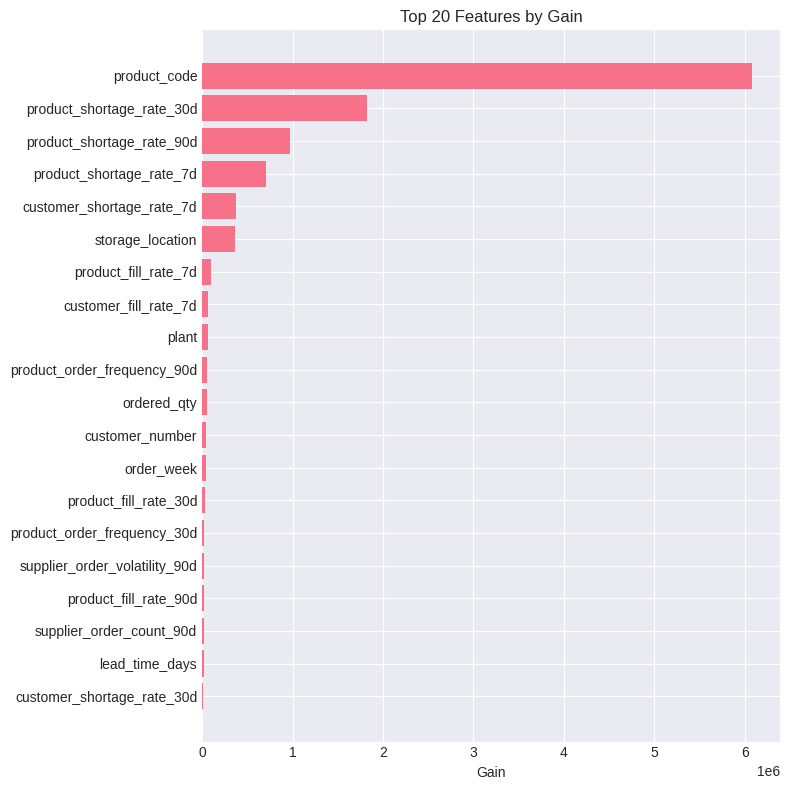

In [40]:
# ============================================================================
# FEATURE IMPORTANCE (GAIN-BASED)
# ============================================================================

print("\n" + "="*80)
print("FEATURE IMPORTANCE (TOP 30)")
print("="*80)

importances = final_model.feature_importance(importance_type="gain")
feature_importance = sorted(
    zip(all_features, importances),
    key=lambda x: x[1],
    reverse=True
)

for name, score in feature_importance[:30]:
    print(f"{name:40s}  {score:.2f}")

# bar plot for top 20
top_feats = feature_importance[:20]
feat_names = [f[0] for f in top_feats]
feat_scores = [f[1] for f in top_feats]

plt.figure(figsize=(8, 8))
plt.barh(range(len(feat_scores)), feat_scores)
plt.yticks(range(len(feat_scores)), feat_names)
plt.gca().invert_yaxis()
plt.title("Top 20 Features by Gain")
plt.xlabel("Gain")
plt.tight_layout()
plt.show()

In [41]:
import os

SAVE_DIR = "/content/drive/MyDrive/hackathon/Artificats"
os.makedirs(SAVE_DIR, exist_ok=True)

print("Saving to:", SAVE_DIR)


Saving to: /content/drive/MyDrive/hackathon/Artificats


In [42]:
model_path = f"{SAVE_DIR}/final_lgbm_model.txt"
final_model.save_model(model_path)
print("Model saved to:", model_path)


Model saved to: /content/drive/MyDrive/hackathon/Artificats/final_lgbm_model.txt


In [43]:
import joblib

encoder_path = f"{SAVE_DIR}/target_encoder.pkl"
joblib.dump(target_encoder, encoder_path)
print("TargetEncoder saved to:", encoder_path)


TargetEncoder saved to: /content/drive/MyDrive/hackathon/Artificats/target_encoder.pkl


In [44]:
feature_cols_path = f"{SAVE_DIR}/feature_columns.pkl"
joblib.dump(all_features, feature_cols_path)
print("Feature column order saved.")


Feature column order saved.


In [45]:
threshold_path = f"{SAVE_DIR}/threshold.json"

import json
with open(threshold_path, "w") as f:
    json.dump({"best_threshold": float(best_threshold)}, f)

print("Threshold saved.")


Threshold saved.


In [46]:
from datetime import datetime

metadata = {
    "model_version": "1.0",
    "timestamp": str(datetime.now()),
    "train_rows": len(X_train),
    "val_rows": len(X_val),
    "test_rows": len(X_test),
    "metrics": {
        "val_auc": float(0.9362),
        "val_pr_auc": float(0.3449),
        "test_auc": float(0.9402),
        "test_pr_auc": float(0.3888),
    },
    "params": best_params_final
}

metadata_path = f"{SAVE_DIR}/metadata.json"

with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=4)

print("Metadata saved.")


Metadata saved.


In [47]:
load_example_path = f"{SAVE_DIR}/load_model_example.py"

with open(load_example_path, "w") as f:
    f.write("""
import joblib
import lightgbm as lgb
import json

SAVE_DIR = "./"  # update this path if needed

# Load model
model = lgb.Booster(model_file=f"{SAVE_DIR}/final_lgbm_model.txt")

# Load encoder
target_encoder = joblib.load(f"{SAVE_DIR}/target_encoder.pkl")

# Load feature columns
all_features = joblib.load(f"{SAVE_DIR}/feature_columns.pkl")

# Load threshold
with open(f"{SAVE_DIR}/threshold.json") as f2:
    threshold = json.load(f2)["best_threshold"]

print("Model, encoder, feature list, and threshold loaded successfully!")
""")

print("Example loader script saved.")


Example loader script saved.


In [48]:
import os
import json
import joblib
import lightgbm as lgb
import numpy as np
import pandas as pd

# ==========================================================
# PATH CONFIGURATION
# ==========================================================
SAVE_DIR = "/content/drive/MyDrive/hackathon/Artificats"
print("Loading from:", SAVE_DIR)

model_path = os.path.join(SAVE_DIR, "final_lgbm_model.txt")
encoder_path = os.path.join(SAVE_DIR, "target_encoder.pkl")
feature_cols_path = os.path.join(SAVE_DIR, "feature_columns.pkl")
threshold_path = os.path.join(SAVE_DIR, "threshold.json")

# ==========================================================
# LOAD ARTIFACTS
# ==========================================================

print("\nLoading artifacts...")

# Load model
model = lgb.Booster(model_file=model_path)
print("✓ Model loaded.")

# Load target encoder
target_encoder = joblib.load(encoder_path)
print("✓ Target encoder loaded.")

# Load feature column order
all_features = joblib.load(feature_cols_path)
print(f"✓ Feature columns loaded ({len(all_features)} features).")

# Load threshold
with open(threshold_path, "r") as f:
    threshold = json.load(f)["best_threshold"]
print(f"✓ Threshold loaded: {threshold}")

print("\nAll artifacts successfully loaded!")


# ==========================================================
# OPTIONAL: TEST THAT THE MODEL CAN RUN A PREDICTION
# ==========================================================

print("\nRunning a quick test prediction...")

# Create a fake row of zeros (just to confirm pipeline loads)
# You will replace this with real engineered feature input later
dummy_input = pd.DataFrame([np.zeros(len(all_features))], columns=all_features)

try:
    pred = model.predict(dummy_input)[0]
    print(f"✓ Test prediction succeeded. Output = {pred}")
except Exception as e:
    print("❌ Prediction failed:", e)


Loading from: /content/drive/MyDrive/hackathon/Artificats

Loading artifacts...
✓ Model loaded.
✓ Target encoder loaded.
✓ Feature columns loaded (47 features).
✓ Threshold loaded: 0.345959670959361

All artifacts successfully loaded!

Running a quick test prediction...
✓ Test prediction succeeded. Output = 0.006092733334624423
